In [1]:
# import packages
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics

from tensorflow import feature_column
from tensorflow.keras import layers

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/Users/abdygaziev/anaconda3/envs/learn-deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/abdygaziev/anaconda3/envs/learn-deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/abdygaziev/anaconda3/envs/learn-deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/abdygaziev/a

In [2]:
df = pd.read_pickle('/Users/abdygaziev/Documents/FlatironMaterials/Projects/train_dummy.pickle')

In [3]:
# from this data we get our target data
df.head(5)

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,...,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
TransactionID,,,,,,,,,,,,,,,,,,,,,
3001687,0,413891,45.000,16661,490.0,150.0,226.0,327.000000,87.00000,1.0,...,0,0,0,0,0,0,0,0,0,0
3001688,0,413902,50.000,6194,498.0,150.0,117.0,337.000000,87.00000,145.0,...,0,0,0,0,0,0,0,0,0,0
3001689,1,413915,160.475,9635,405.0,185.0,226.0,290.733794,86.80063,1.0,...,0,0,0,0,0,0,0,0,0,0
3001690,0,413942,50.000,11207,361.0,150.0,226.0,126.000000,87.00000,1.0,...,0,0,0,0,0,0,0,0,0,0
3001692,0,413957,50.000,12544,321.0,150.0,226.0,476.000000,87.00000,1.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.shape

(533007, 267)

In [5]:
# examining classes
neg, pos = np.bincount(df['isFraud'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 533007
    Positive: 17838 (3.35% of total)



In [6]:
cleaned_df = df.copy()

# The `Amount` column covers a huge range. Convert to log-space.
eps=0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('TransactionAmt')+eps)

In [7]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('isFraud'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('isFraud'))
test_labels = np.array(test_df.pop('isFraud'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [9]:
#Normalize the input features using the sklearn StandardScaler. 
#This will set the mean to 0 and standard deviation to 1.
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (341124,)
Validation labels shape: (85281,)
Test labels shape: (106602,)
Training features shape: (341124, 266)
Validation features shape: (85281, 266)
Test features shape: (106602, 266)


In [10]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
            16, activation='relu',
            input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
#buidling a model
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [12]:
model = make_model()
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                4272      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.predict(train_features[:10])

array([[0.7898536 ],
       [0.66407096],
       [0.7127557 ],
       [0.539934  ],
       [0.82806337],
       [0.7258838 ],
       [0.4800256 ],
       [0.5114473 ],
       [0.5667137 ],
       [0.51073533]], dtype=float32)

In [14]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.0897


In [15]:
initial_bias = np.log([pos/neg])
initial_bias

array([-3.36316399])

In [16]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.05748177],
       [0.3839926 ],
       [0.12709501],
       [0.13615778],
       [0.04106671],
       [0.06793734],
       [0.176606  ],
       [0.10187042],
       [0.1994155 ],
       [0.08946632]], dtype=float32)

In [17]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.2128


In [18]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


In [19]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

Instructions for updating:
Use tf.cast instead.


In [20]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [23]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [24]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'], color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
              color=colors[n], label='Val '+label,
              linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

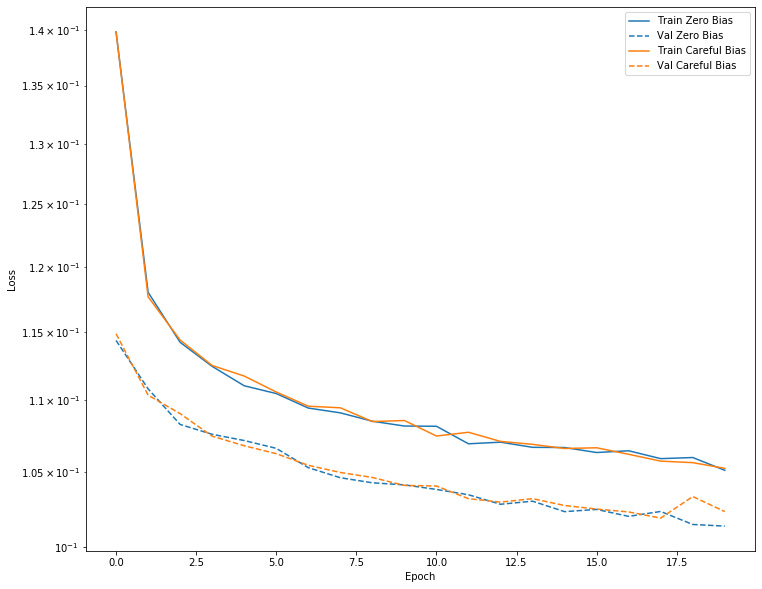

In [25]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Train on 341124 samples, validate on 85281 samples
Epoch 1/100
341124/341124 [==============================] - 5s 15us/sample - loss: 0.1386 - tp: 1147.0000 - fp: 1785.0000 - tn: 327898.0000 - fn: 10294.0000 - accuracy: 0.9646 - precision: 0.3912 - recall: 0.1003 - val_loss: 0.1140 - val_tp: 280.0000 - val_fp: 60.0000 - val_tn: 82376.0000 - val_fn: 2565.0000 - val_accuracy: 0.9692 - val_precision: 0.8235 - val_recall: 0.0984
Epoch 2/100
341124/341124 [==============================] - 5s 14us/sample - loss: 0.1182 - tp: 1457.0000 - fp: 626.0000 - tn: 329057.0000 - fn: 9984.0000 - accuracy: 0.9689 - precision: 0.6995 - recall: 0.1273 - val_loss: 0.1110 - val_tp: 318.0000 - val_fp: 63.0000 - val_tn: 82373.0000 - val_fn: 2527.0000 - val_accuracy: 0.9696 - val_precision: 0.8346 - val_recall: 0.1118
Epoch 3/100
341124/341124 [==============================] - 5s 15us/sample - loss: 0.1142 - tp: 1637.0000 - fp: 605.0000 - tn: 329078.0000 - fn: 9804.0000 - accuracy: 0.9695 - precision: 0.730

In [30]:
def plot_metrics(history):
    metrics =  ['loss', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()


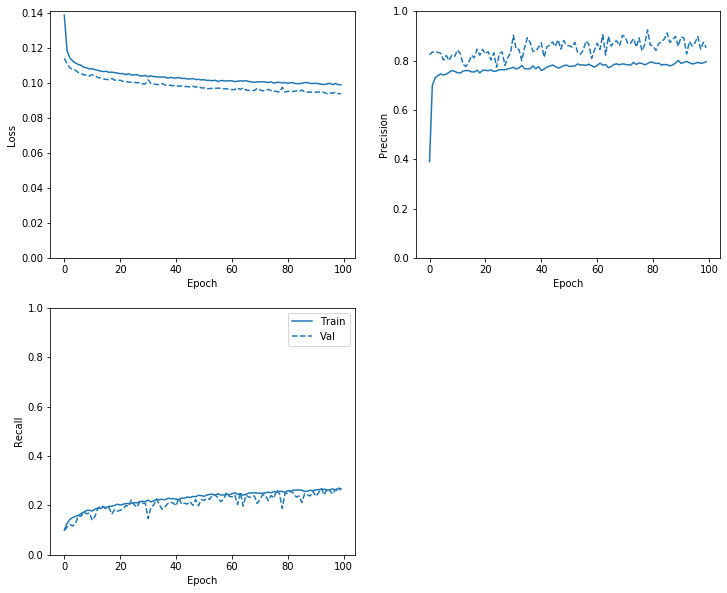

In [31]:
plot_metrics(baseline_history)